In [1]:
!pip install numpy==1.26


In [2]:
!pip install rdkit-pypi


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models


In [21]:
from google.colab import files
uploaded = files.upload()


Saving DataSet.csv to DataSet (2).csv


In [22]:
df = pd.read_csv('DataSet.csv')
df.head()


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,Value
0,CHEMBL96580,NaN,NaN,316.45,0.0,4.75,7e,CN(C/C=C/C#CC(C)(C)C)Cc1ccc(C#N)c2ccccc12,MIC,'>',...,CHEMBL1127027,1.0,Scientific Literature,J Med Chem,1993.0,NaN,NaN,NaN,NaN,200.00
1,CHEMBL386918,NaN,NaN,1049.23,NaN,NaN,10,CCC(C)CC(C)CCCCCCCCC(=O)N[C@H]1C[C@@H](O)CNC(=...,MFC,'=',...,CHEMBL1128045,1.0,Scientific Literature,Bioorg Med Chem Lett,1995.0,NaN,NaN,NaN,NaN,0.25
2,CHEMBL328745,NaN,NaN,549.71,2.0,5.32,4c,CC(C)C1=CC2CC3(C=O)[C@@H]4CC[C@@H](C)[C@H]4CC2...,MIC,'=',...,CHEMBL1135349,1.0,Scientific Literature,Bioorg Med Chem Lett,2002.0,NaN,NaN,NaN,NaN,0.25
3,CHEMBL2371766,NaN,NaN,1734.07,NaN,NaN,7b,CCCCCCCCCCCCC[C@@H]1CC(=O)N[C@@H]([C@@H](C)O)C...,IC50,'=',...,CHEMBL1134059,1.0,Scientific Literature,Bioorg Med Chem Lett,2001.0,NaN,NaN,NaN,NaN,0.55
4,CHEMBL53935,NaN,NaN,333.43,0.0,4.07,4,CCOC(=O)c1oc2cccc(OCCCNC(C)(C)C)c2c1C,IC50,'=',...,CHEMBL1134137,1.0,Scientific Literature,Bioorg Med Chem Lett,2001.0,NaN,NaN,NaN,NaN,300.00


In [23]:
needed_cols = ['Smiles', 'Standard Type', 'Standard Value', 'Standard Units']
df = df[needed_cols]
df = df.dropna()
df = df[df['Standard Type'].str.upper() == 'IC50']
df = df[df['Standard Units'].str.lower() == 'nm']
df = df.reset_index(drop=True)
df.head()


,Smiles,Standard Type,Standard Value,Standard Units
0,CCOC(=O)c1oc2cccc(OCCCNC(C)(C)C)c2c1C,IC50,300000.0,nM
1,CC[C@@H](C)[C@@H](NC(=O)[C@@H](Cc1ccccc1)NC(=O...,IC50,14910.0,nM
2,CC(C)N1CCN(c2ccc(N3CCN(c4ccc(OC[C@H]5OC[C@](Cn...,IC50,40.0,nM
3,CC(C)N1CCN(c2ccc(N3CCN(c4ccc(OC[C@H]5OC[C@](Cn...,IC50,1830.0,nM
4,C1=C[C@H](c2ccccc2)OO[C@@H]1c1ccccc1,IC50,31000.0,nM


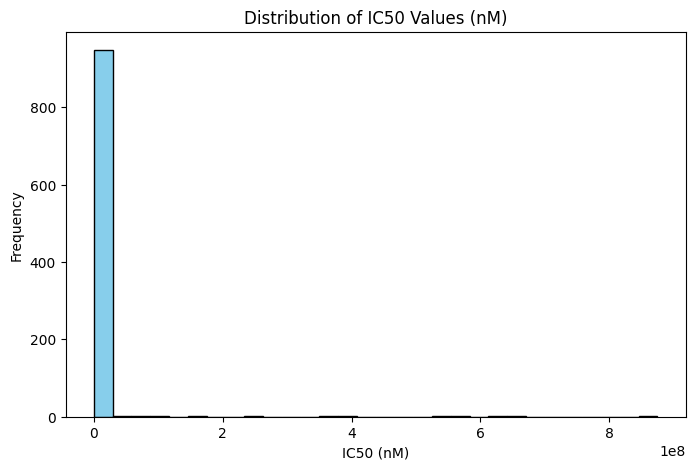

In [24]:
plt.figure(figsize=(8,5))
plt.hist(df['Standard Value'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of IC50 Values (nM)')
plt.xlabel('IC50 (nM)')
plt.ylabel('Frequency')
plt.show()


In [34]:
def smiles_to_morgan_fp(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((n_bits,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    array = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, array)
    return array

fingerprint_array = np.array([smiles_to_morgan_fp(s) for s in df['Smiles']])

X = pd.DataFrame(fingerprint_array)
y = df['Standard Value'].values

print(" Featurization complete!")
print("X shape:", X.shape)
print("y shape:", y.shape)


 Featurization complete!
X shape: (968, 2048)
y shape: (968,)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(" Train shape:", X_train.shape)
print(" Test shape:", X_test.shape)


 Train shape: (774, 2048)
 Test shape: (194, 2048)


In [36]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),  # Novelty: regularization
    layers.Dense(256, activation='relu'),
    layers.Dense(1)  # Regression output
])

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,180,673 (4.50 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4489725272391680.0000 - mae: 8691009.0000 - val_loss: 2655222602137600.0000 - val_mae: 6477548.0000
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2829203674234880.0000 - mae: 5724977.0000 - val_loss: 2655220723089408.0000 - val_mae: 6477328.0000
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3407752680439808.0000 - mae: 7505305.5000 - val_loss: 2655216159686656.0000 - val_mae: 6476886.5000
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3948565567111168.0000 - mae: 8498734.0000 - val_loss: 2655208106622976.0000 - val_mae: 6476252.5000
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5454217087025152.0000 - mae: 10031626.0000 - val_loss: 2655193879543808.0000 - val_mae: 6475649.5000
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4269118035329024.0000 - mae: 7705624.0000 - val_loss: 2655170257223680.0000 - val_mae: 6475057.5000
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms

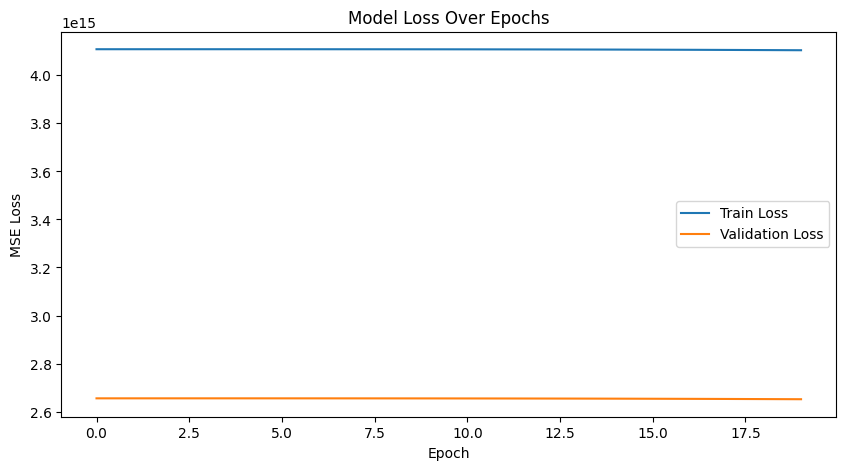

In [38]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [39]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_loss:.2f}")
print(f"Test MAE: {test_mae:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4334987264393216.0000 - mae: 8872910.0000  
Test MSE: 2651520071892992.00
Test MAE: 6474949.50


In [40]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

ridge_mse = mean_squared_error(y_test, ridge_pred)
print(f" Ridge Regression Test MSE: {ridge_mse:.2f}")


 Ridge Regression Test MSE: 2859836002157939.00


In [42]:
y_pred = model.predict(X_test).flatten()

for i in range(10):
    print(f"Example {i+1}: True IC50 = {y_test[i]:.2f} nM — Predicted = {y_pred[i]:.2f} nM")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Example 1: True IC50 = 740.00 nM — Predicted = 68986.52 nM
Example 2: True IC50 = 31000.00 nM — Predicted = 133830.41 nM
Example 3: True IC50 = 13700.00 nM — Predicted = 31916.37 nM
Example 4: True IC50 = 20.00 nM — Predicted = 60861.44 nM
Example 5: True IC50 = 700.00 nM — Predicted = 54478.93 nM
Example 6: True IC50 = 5700.00 nM — Predicted = 41435.70 nM
Example 7: True IC50 = 230900.00 nM — Predicted = 160648.02 nM
Example 8: True IC50 = 74.00 nM — Predicted = 46985.10 nM
Example 9: True IC50 = 1970.00 nM — Predicted = 29141.18 nM
Example 10: True IC50 = 561600000.00 nM — Predicted = 290458.25 nM


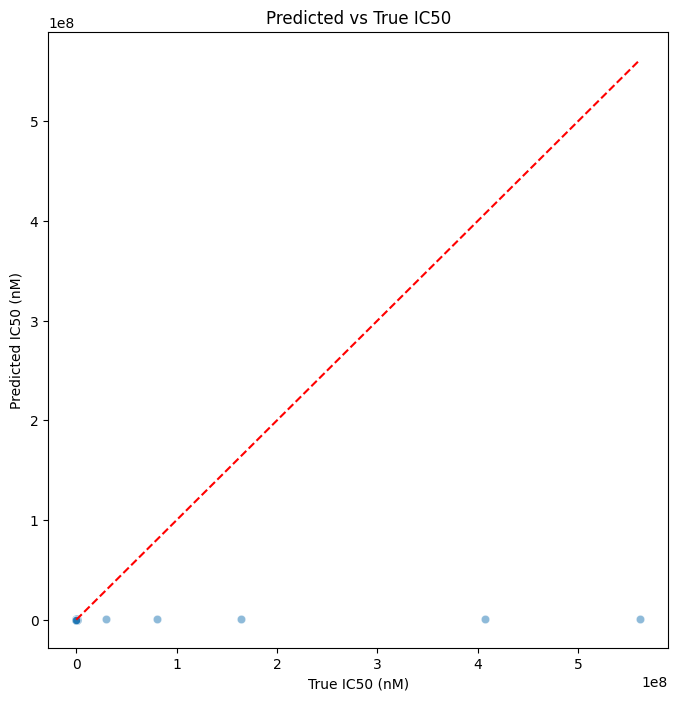

In [43]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True IC50 (nM)')
plt.ylabel('Predicted IC50 (nM)')
plt.title('Predicted vs True IC50')
plt.show()


In [44]:
results_df = pd.DataFrame({
    'True_IC50_nM': y_test,
    'Predicted_IC50_nM': y_pred
})

results_df.to_csv('IC50_Predictions.csv', index=False)
print("Saved predictions to IC50_Predictions.csv")


Saved predictions to IC50_Predictions.csv
